In [1]:
import pandas as pd
import numpy as np
import random as rand
import tqdm
import networkx as nx
import pickle as pkl
import gower
import matplotlib.pyplot as plt
import methods
from methods import topK, findGroups, ranking, getAttributes, Q, Q2, Discovery

In [2]:
from torch_geometric.datasets import WebKB

dataset = WebKB(root='./data/GNNBenchmarkDataset', name='Cornell')

# Access the first graph in the dataset
data = dataset[0]

# Print basic information about the dataset
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node feature matrix shape: {data.x.shape}")  # Node features
print(f"Number of classes: {data.y.unique().size(0)}")  # Number of distinct classes
print(f"First node's features: {data.x[0]}")


Number of nodes: 183
Number of edges: 298
Node feature matrix shape: torch.Size([183, 1703])
Number of classes: 5
First node's features: tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [3]:
class CustomGraphDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        # Extract a graph from the dataset
        graph_data = self.dataset[idx]
        
        # Convert to the desired dictionary format similar to GraphPropPredDataset
        graph = {
            'edge_index': graph_data.edge_index,  # Edge index
            'num_nodes': graph_data.num_nodes,  # Number of nodes
            'node_feat': graph_data.x  # Node features (if available)
        }
        
        label = graph_data.y
        return graph, label

    def __len__(self):
        return len(self.dataset)

# Instantiate the custom dataset
custom_dataset = CustomGraphDataset(dataset)
graph, label = custom_dataset[0]



In [4]:
edge_index = graph['edge_index']
num_nodes = graph['num_nodes']
edge_index = data.edge_index 
num_nodes = data.num_nodes 
G = nx.Graph()

G.add_nodes_from(range(num_nodes))

edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))  # Convert tensor to list of tuples
G.add_edges_from(edges)

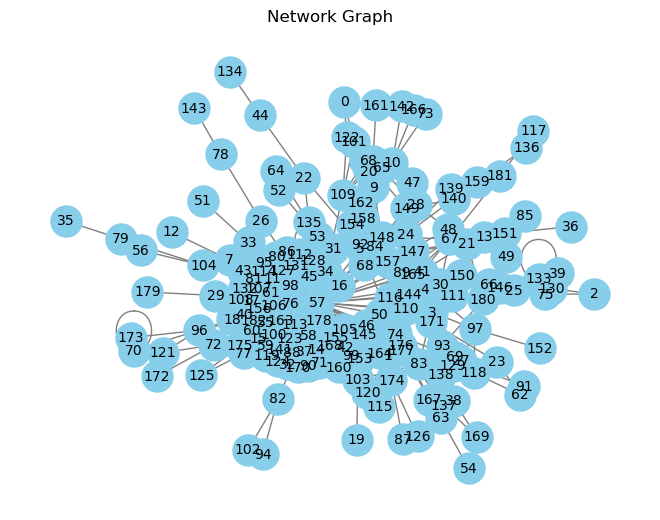

In [5]:
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Network Graph")
plt.show()

In [6]:
academic_classes = [0, 1, 2]  # Student, Professor, Course so (False = project/staff)
binary_target = data.y.apply_(lambda x: 1 if x in academic_classes else 0)
binary_target

tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [7]:
attributes = graph['node_feat']
lu = pd.DataFrame(attributes)
lu['target'] = binary_target == 1 # this 
lu.head()

,0,1,2,3,4,5,6,7,8,9,...,1694,1695,1696,1697,1698,1699,1700,1701,1702,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [8]:
result_normal = findGroups(G, 20, lu, ablation_mode=False)
result_normal

100%|██████████| 183/183 [00:45<00:00,  3.99it/s]


,rho,sigma,q,ranks,reference,subgroup
node,,,,,,
78,22,4,0.242274,"[(78, True), (26, False), (143, True), (57, Tr...","[78, 26, 143, 57, 170, 119, 14, 59, 168, 18, 5...","[78, 26, 143, 57]"
60,24,4,0.238145,"[(60, True), (57, True), (119, False), (59, Tr...","[60, 57, 119, 59, 168, 18, 132, 174, 157, 131,...","[60, 57, 119, 59]"
76,36,4,0.231481,"[(76, True), (57, True), (60, True), (127, Tru...","[76, 57, 60, 127, 119, 168, 174, 59, 45, 14, 1...","[76, 57, 60, 127]"
135,36,11,0.228925,"[(135, True), (64, True), (5, False), (57, Tru...","[135, 64, 5, 57, 22, 110, 18, 103, 45, 92, 59,...","[135, 64, 5, 57, 22, 110, 18, 103, 45, 92, 59]"
165,36,5,0.225677,"[(165, False), (149, True), (67, True), (97, T...","[165, 149, 67, 97, 57, 174, 110, 119, 144, 157...","[165, 149, 67, 97, 57]"
30,43,6,0.224416,"[(30, False), (25, True), (67, True), (146, Tr...","[30, 25, 67, 146, 57, 66, 110, 13, 144, 174, 1...","[30, 25, 67, 146, 57, 66]"
113,33,3,0.219281,"[(113, True), (57, True), (60, True), (119, Fa...","[113, 57, 60, 119, 59, 168, 40, 157, 174, 18, ...","[113, 57, 60]"
157,19,3,0.202165,"[(157, False), (48, True), (57, True), (119, F...","[157, 48, 57, 119, 174, 18, 168, 59, 131, 170,...","[157, 48, 57]"
59,20,3,0.200104,"[(59, True), (57, True), (119, False), (168, F...","[59, 57, 119, 168, 18, 131, 170, 98, 157, 174,...","[59, 57, 119]"


In [9]:
result_normal.to_csv('subgroups_cornell.csv')

In [9]:
result_ablation = findGroups(G, 20, lu, ablation_mode=True)
result_ablation

100%|██████████| 183/183 [00:45<00:00,  4.01it/s]


,rho,sigma,q,ranks,reference,subgroup
node,,,,,,
156,183,37,0.145633,"[(156, False), (57, True), (18, False), (98, F...","[156, 57, 18, 98, 124, 119, 45, 157, 168, 174,...","[156, 57, 18, 98, 124, 119, 45, 157, 168, 174,..."
109,183,31,0.135815,"[(109, False), (20, False), (122, False), (57,...","[109, 20, 122, 57, 8, 6, 101, 119, 98, 59, 178...","[109, 20, 122, 57, 8, 6, 101, 119, 98, 59, 178..."
107,183,26,0.129525,"[(107, False), (57, True), (119, False), (157,...","[107, 57, 119, 157, 174, 18, 170, 168, 59, 132...","[107, 57, 119, 157, 174, 18, 170, 168, 59, 132..."
155,183,20,0.118687,"[(155, False), (168, False), (99, False), (57,...","[155, 168, 99, 57, 119, 18, 59, 131, 124, 132,...","[155, 168, 99, 57, 119, 18, 59, 131, 124, 132,..."
32,183,10,0.103085,"[(32, True), (57, True), (113, True), (60, Tru...","[32, 57, 113, 60, 107, 80, 114, 127, 59, 82, 4...","[32, 57, 113, 60, 107, 80, 114, 127, 59, 82]"
111,183,6,0.097957,"[(111, True), (116, True), (57, True), (77, Tr...","[111, 116, 57, 77, 53, 45, 18, 59, 112, 124, 4...","[111, 116, 57, 77, 53, 45]"
33,183,6,0.097957,"[(33, True), (57, True), (51, True), (86, True...","[33, 57, 51, 86, 31, 141, 18, 119, 177, 103, 1...","[33, 57, 51, 86, 31, 141]"
81,183,6,0.097957,"[(81, True), (57, True), (31, True), (141, Tru...","[81, 57, 31, 141, 86, 177, 14, 42, 119, 18, 16...","[81, 57, 31, 141, 86, 177]"
153,183,24,0.090783,"[(153, True), (160, False), (120, False), (176...","[153, 160, 120, 176, 57, 119, 18, 38, 59, 168,...","[153, 160, 120, 176, 57, 119, 18, 38, 59, 168,..."


In [10]:
from ablation_metrics import compare_subgroups

comparison = compare_subgroups(result_normal, result_ablation, k=10)
comparison

{'avg_q_normal': 0.22110181586920122,
 'avg_q_ablation': 0.11034318194466348,
 'avg_ref_size_normal': 30.9,
 'avg_ref_size_ablation': 183.0,
 'avg_sub_size_normal': 4.6,
 'avg_sub_size_ablation': 20.6,
 'avg_subgroup_overlap': 0.08989953293832603}

In [11]:
from ablation_metrics import evaluate_pattern_subgroups

mean_ratio_normal, dist_ratios_normal = evaluate_pattern_subgroups(result_normal, lu, k=10)
mean_ratio_ablation, dist_ratios_ablation = evaluate_pattern_subgroups(result_ablation, lu, k=10)

print("Avg fraction of target=1 in top-10 normal subgroups: ", mean_ratio_normal)
print("Avg fraction of target=1 in top-10 ablation subgroups:", mean_ratio_ablation)

Avg fraction of target=1 in top-10 normal subgroups:  0.8103030303030302
Avg fraction of target=1 in top-10 ablation subgroups: 0.48628853419176005


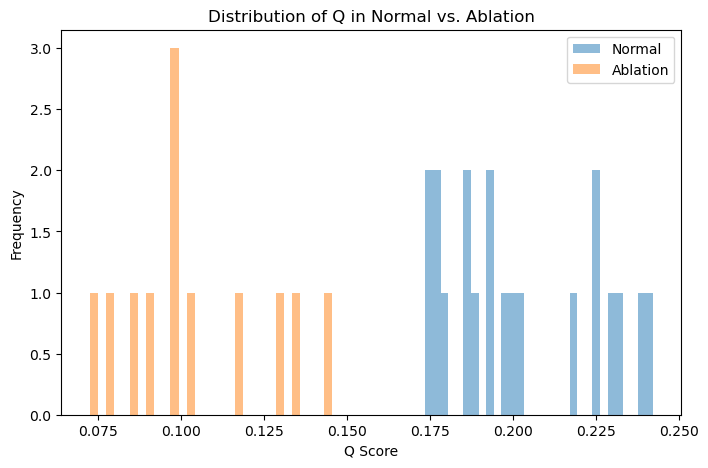

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(result_normal['q'], bins=30, alpha=0.5, label='Normal')
plt.hist(result_ablation['q'], bins=30, alpha=0.5, label='Ablation')
plt.xlabel('Q Score')
plt.ylabel('Frequency')
plt.title('Distribution of Q in Normal vs. Ablation')
plt.legend()
plt.show()